### Comparison to Observational Data

###### Preliminaries:

In [4]:
wnd_obs_nc = xarray.open_dataset('/data/met/ECMWF-ERAINT/dmo/pr_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
wnd_obs_nc

<xarray.Dataset>
Dimensions:    (latitude: 23, longitude: 37, time: 14153)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2019-08-31
  * latitude   (latitude) float32 46.0 46.75 47.5 48.25 ... 61.0 61.75 62.5
  * longitude  (longitude) float32 -19.0 -18.25 -17.5 -16.75 ... 6.5 7.25 8.0
Data variables:
    pr         (time, latitude, longitude) float32 ...

In [1]:
# Preliminaries:
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))
        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))
    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    return directories,tas_files,hurs_files,wind_files,pr_files

In [23]:
wnd_obs_nc = xarray.open_dataset('/data/met/ECMWF-ERAINT/dmo/sfcWind_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
prc_obs_nc = xarray.open_dataset('/data/met/ECMWF-ERAINT/dmo/pr_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
prc_uk = xarray.open_dataset(f'/home/theo/data/ukcp18/pr_rcp85_ukcp18_natgb_05_day_19801201-20801130.nc')
mask_os_nc = xarray.open_dataset('/home/theo/data/land-sea_mask_uk_12km-osgb.nc', engine = "netcdf4")
wnd_obs_nc

<xarray.Dataset>
Dimensions:    (latitude: 23, longitude: 37, time: 14153)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2019-08-31
  * latitude   (latitude) float32 46.0 46.75 47.5 48.25 ... 61.0 61.75 62.5
  * longitude  (longitude) float32 -19.0 -18.25 -17.5 -16.75 ... 6.5 7.25 8.0
Data variables:
    sfcWind    (time, latitude, longitude) float32 ...

###### Loading Data:

In [26]:
# Loading Observational Data:
tas_obs_nc = xarray.open_dataset('/data/met/ECMWF-ERAINT/dmo/tas_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
wnd_obs_nc = xarray.open_dataset('/data/met/ECMWF-ERAINT/dmo/sfcWind_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
prc_obs_nc = xarray.open_dataset('/data/met/ECMWF-ERAINT/dmo/pr_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
mask_os_nc = xarray.open_dataset('/home/theo/data/land-sea_mask_uk_12km-osgb.nc', engine = "netcdf4")

tas_obs = tas_obs_nc.tas
wnd_obs = wnd_obs_nc.sfcWind*3.6
prc_obs = prc_obs_nc.pr
mask_os = mask_os_nc.lsm

#tas_obs_land = np.einsum('ijk,jk->ijk',tas_obs,mask_os)
#wnd_obs_land = np.einsum('ijk,jk->ijk',wnd_obs,mask_os)
#prc_obs_land = np.einsum('ijk,jk->ijk',prc_obs,mask_os)

years_obs = np.array(pd.to_datetime(np.array(tas_obs_nc.time)).year)
month_obs = np.array(pd.to_datetime(np.array(tas_obs_nc.time)).month)
summer_inds_obs =np.concatenate((np.where(month_obs == 6)[0],np.where(month_obs == 7)[0],np.where(month_obs == 8)[0]),axis = 0)

temp_obs = np.empty((39,5))
wind_obs = np.empty((39,5))
rain_obs = np.empty((39,5))

for i in range(1981,2020):
    years = np.where(years_obs == i)
    inds  = np.intersect1d(years,summer_inds_obs)

    temp_obs[i-1981,0] = np.nanpercentile(tas_obs[inds,:,:],5)
    temp_obs[i-1981,1] = np.nanpercentile(tas_obs[inds,:,:],25)
    temp_obs[i-1981,2] = np.nanpercentile(tas_obs[inds,:,:],50)
    temp_obs[i-1981,3] = np.nanpercentile(tas_obs[inds,:,:],75)
    temp_obs[i-1981,4] = np.nanpercentile(tas_obs[inds,:,:],95)
    
    wind_obs[i-1981,0] = np.nanpercentile(wnd_obs[inds,:,:],5)
    wind_obs[i-1981,1] = np.nanpercentile(wnd_obs[inds,:,:],25)
    wind_obs[i-1981,2] = np.nanpercentile(wnd_obs[inds,:,:],50)
    wind_obs[i-1981,3] = np.nanpercentile(wnd_obs[inds,:,:],75)
    wind_obs[i-1981,4] = np.nanpercentile(wnd_obs[inds,:,:],95)
    
    rain_obs[i-1981,0] = np.nanpercentile(wnd_obs[inds,:,:],5)
    rain_obs[i-1981,1] = np.nanpercentile(wnd_obs[inds,:,:],25)
    rain_obs[i-1981,2] = np.nanpercentile(wnd_obs[inds,:,:],50)
    rain_obs[i-1981,3] = np.nanpercentile(wnd_obs[inds,:,:],75)
    rain_obs[i-1981,4] = np.nanpercentile(wnd_obs[inds,:,:],95)

In [3]:
del tas_obs_nc,wnd_obs_nc,prc_obs_nc,mask_os_nc,tas_obs,wnd_obs,prc_obs,mask_os,tas_obs_land,wnd_obs_land,prc_obs_land

In [27]:
np.save('/home/theo/outdata/4.outdata/temp_obs_all',temp_obs)
np.save('/home/theo/outdata/4.outdata/wind_obs_all',wind_obs)
np.save('/home/theo/outdata/4.outdata/rain_obs_all',rain_obs)

In [5]:
# Loading EuroCORDEX data:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
mask = region_mask == 0
mask[mask == 0] = np.nan

temp = np.empty((48,39,5))
wind = np.empty((48,39,5))
rain = np.empty((48,39,5))

for j in range(1,49):
    
    tas = xarray.open_dataset(directories[j] + tas_files[j], engine = "netcdf4")
    wnd = xarray.open_dataset(directories[j] + wind_files[j], engine = "netcdf4")
    prc = xarray.open_dataset(directories[j] + pr_files[j], engine = "netcdf4")
    
    tas_land = np.einsum('ijk,jk->ijk',tas.tas - 273.15,mask)
    wnd_land = np.einsum('ijk,jk->ijk',wnd.sfcWind * 3.6,mask)
    prc_land = np.einsum('ijk,jk->ijk',prc.pr * 86400,mask)
    
    print(j)

    try:
        years = np.array(pd.to_datetime(np.array(tas.time)).year)
        month = np.array(pd.to_datetime(np.array(tas.time)).month)
    except:
        years = np.vectorize(lambda x: x.year)(np.array(tas.time))
        month = np.vectorize(lambda x: x.month)(np.array(tas.time))
    
    summer_inds = np.concatenate((np.where(month == 6)[0],np.where(month == 7)[0],np.where(month == 8)[0]),axis = 0)
    
    del tas,wnd,prc
    
    inds = np.array([np.intersect1d(np.where(years == i),summer_inds) for i in range(1981,2020)])
    
    temp[j-1,:,0] = np.array([np.nanpercentile(tas_land[inds[j,:],:,:],5) for j in range(inds.shape[0])])
    wind[j-1,:,0] = np.array([np.nanpercentile(wnd_land[inds[j,:],:,:],5) for j in range(inds.shape[0])])
    rain[j-1,:,0] = np.array([np.nanpercentile(prc_land[inds[j,:],:,:],5) for j in range(inds.shape[0])])
    
    temp[j-1,:,1] = np.array([np.nanpercentile(tas_land[inds[j,:],:,:],25) for j in range(inds.shape[0])])
    wind[j-1,:,1] = np.array([np.nanpercentile(wnd_land[inds[j,:],:,:],25) for j in range(inds.shape[0])])
    rain[j-1,:,1] = np.array([np.nanpercentile(prc_land[inds[j,:],:,:],25) for j in range(inds.shape[0])])
    
    temp[j-1,:,2] = np.array([np.nanpercentile(tas_land[inds[j,:],:,:],50) for j in range(inds.shape[0])])
    wind[j-1,:,2] = np.array([np.nanpercentile(wnd_land[inds[j,:],:,:],50) for j in range(inds.shape[0])])
    rain[j-1,:,2] = np.array([np.nanpercentile(prc_land[inds[j,:],:,:],50) for j in range(inds.shape[0])])
    
    temp[j-1,:,3] = np.array([np.nanpercentile(tas_land[inds[j,:],:,:],75) for j in range(inds.shape[0])])
    wind[j-1,:,3] = np.array([np.nanpercentile(wnd_land[inds[j,:],:,:],75) for j in range(inds.shape[0])])
    rain[j-1,:,3] = np.array([np.nanpercentile(prc_land[inds[j,:],:,:],75) for j in range(inds.shape[0])])
    
    temp[j-1,:,4] = np.array([np.nanpercentile(tas_land[inds[j,:],:,:],95) for j in range(inds.shape[0])])
    wind[j-1,:,4] = np.array([np.nanpercentile(wnd_land[inds[j,:],:,:],95) for j in range(inds.shape[0])])
    rain[j-1,:,4] = np.array([np.nanpercentile(prc_land[inds[j,:],:,:],95) for j in range(inds.shape[0])])

    
    del tas_land, wnd_land, prc_land,years,month,summer_inds

<class 'list'>


KeyboardInterrupt: 

In [26]:
np.save('/home/theo/outdata/4.outdata/temp_ukcordex',temp)
np.save('/home/theo/outdata/4.outdata/wind_ukcordex',wind)
np.save('/home/theo/outdata/4.outdata/rain_ukcordex',rain)

In [116]:
# Loading UKCP18 data:
tags = ['01','04','05','06','07','08','09','10','11','12','13','15']

region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
mask = region_mask == 0
mask[mask == 0] = np.nan

temp_uk = np.empty((len(tags),39,5))
wind_uk = np.empty((len(tags),39,5))
rain_uk = np.empty((len(tags),39,5))

for j in range(len(tags)):
    
    print(j+1)
    
    tas_uk = xarray.open_dataset(f'/home/theo/data/ukcp18/tas_rcp85_ukcp18_natgb_{tags[j]}_day_19801201-20801130.nc')
    wnd_uk = xarray.open_dataset(f'/home/theo/data/ukcp18/sfcWind_rcp85_ukcp18_natgb_{tags[j]}_day_19801201-20801130.nc')
    prc_uk = xarray.open_dataset(f'/home/theo/data/ukcp18/pr_rcp85_ukcp18_natgb_{tags[j]}_day_19801201-20801130.nc')
    
    tas_land_uk = np.einsum('ijk,jk->ijk',tas_uk.tas[:,:,:,0],mask)
    wnd_land_uk = np.einsum('ijk,jk->ijk',wnd_uk.sfcWind[:,:,:,0]*3.6,mask)
    prc_land_uk = np.einsum('ijk,jk->ijk',prc_uk.pr[:,:,:,0],mask)

    try:
        years = np.array(pd.to_datetime(np.array(tas_uk.time)).year)
        month = np.array(pd.to_datetime(np.array(tas_uk.time)).month)
    except:
        years = np.vectorize(lambda x: x.year)(np.array(tas_uk.time))
        month = np.vectorize(lambda x: x.month)(np.array(tas_uk.time))
    
    summer_inds = np.concatenate((np.where(month == 6)[0],np.where(month == 7)[0],np.where(month == 8)[0]),axis = 0)
    
    del tas_uk,wnd_uk,prc_uk
    
    inds = np.array([np.intersect1d(np.where(years == i),summer_inds) for i in range(1981,2020)])
    
    temp_uk[j-1,:,0] = np.array([np.nanpercentile(tas_land_uk[inds[j,:],:,:],5) for j in range(inds.shape[0])])
    wind_uk[j-1,:,0] = np.array([np.nanpercentile(wnd_land_uk[inds[j,:],:,:],5) for j in range(inds.shape[0])])
    rain_uk[j-1,:,0] = np.array([np.nanpercentile(prc_land_uk[inds[j,:],:,:],5) for j in range(inds.shape[0])])
    
    temp_uk[j-1,:,1] = np.array([np.nanpercentile(tas_land_uk[inds[j,:],:,:],25) for j in range(inds.shape[0])])
    wind_uk[j-1,:,1] = np.array([np.nanpercentile(wnd_land_uk[inds[j,:],:,:],25) for j in range(inds.shape[0])])
    rain_uk[j-1,:,1] = np.array([np.nanpercentile(prc_land_uk[inds[j,:],:,:],25) for j in range(inds.shape[0])])
    
    temp_uk[j-1,:,2] = np.array([np.nanpercentile(tas_land_uk[inds[j,:],:,:],50) for j in range(inds.shape[0])])
    wind_uk[j-1,:,2] = np.array([np.nanpercentile(wnd_land_uk[inds[j,:],:,:],50) for j in range(inds.shape[0])])
    rain_uk[j-1,:,2] = np.array([np.nanpercentile(prc_land_uk[inds[j,:],:,:],50) for j in range(inds.shape[0])])
    
    temp_uk[j-1,:,3] = np.array([np.nanpercentile(tas_land_uk[inds[j,:],:,:],75) for j in range(inds.shape[0])])
    wind_uk[j-1,:,3] = np.array([np.nanpercentile(wnd_land_uk[inds[j,:],:,:],75) for j in range(inds.shape[0])])
    rain_uk[j-1,:,3] = np.array([np.nanpercentile(prc_land_uk[inds[j,:],:,:],75) for j in range(inds.shape[0])])
    
    temp_uk[j-1,:,4] = np.array([np.nanpercentile(tas_land_uk[inds[j,:],:,:],95) for j in range(inds.shape[0])])
    wind_uk[j-1,:,4] = np.array([np.nanpercentile(wnd_land_uk[inds[j,:],:,:],95) for j in range(inds.shape[0])])
    rain_uk[j-1,:,4] = np.array([np.nanpercentile(prc_land_uk[inds[j,:],:,:],95) for j in range(inds.shape[0])])
    
    del tas_land_uk, wnd_land_uk, prc_land_uk

1
2
3
4
5
6
7
8
9
10
11
12


In [117]:
np.save('/home/theo/outdata/4.outdata/temp_ukcp18',temp_uk)
np.save('/home/theo/outdata/4.outdata/wind_ukcp18',wind_uk)
np.save('/home/theo/outdata/4.outdata/rain_ukcp18',rain_uk)

###### Making Plots

In [5]:
temp_obs = np.load('/home/theo/outdata/4.outdata/temp_obs_all.npy')
wind_obs = np.load('/home/theo/outdata/4.outdata/wind_obs_all.npy')
rain_obs = np.load('/home/theo/outdata/4.outdata/rain_obs_all.npy')

# With attempted land mask:
#temp_obs = np.load('/home/theo/outdata/4.outdata/temp_obs.npy')
#wind_obs = np.load('/home/theo/outdata/4.outdata/wind_obs.npy')
#rain_obs = np.load('/home/theo/outdata/4.outdata/rain_obs.npy')

temp_ukcp18 = np.load('/home/theo/outdata/4.outdata/temp_ukcp18.npy')
wind_ukcp18 = np.load('/home/theo/outdata/4.outdata/wind_ukcp18.npy')
rain_ukcp18 = np.load('/home/theo/outdata/4.outdata/rain_ukcp18.npy')

temp_cordex = np.load('/home/theo/outdata/4.outdata/temp_ukcordex.npy')
wind_cordex = np.load('/home/theo/outdata/4.outdata/wind_ukcordex.npy')
rain_cordex = np.load('/home/theo/outdata/4.outdata/rain_ukcordex.npy')

###### Temperature:

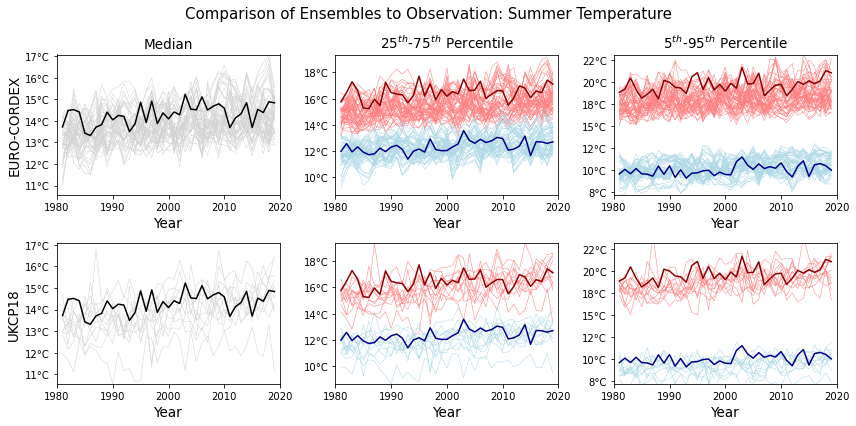

In [9]:
# Temperature
cordex_lines = temp_cordex
ukcp18_lines = temp_ukcp18
obsrvd_lines = temp_obs
title_string = 'Temperature'
save_str = 'tas'


dates = [1981 + i for i in range(39)]
# Median
plt.rcParams["figure.figsize"] = (12,6)
fig,ax = plt.subplots(2,3)
fig.suptitle(f'Comparison of Ensembles to Observation: Summer Temperature',fontsize = 15)

cordex_plots = [ax[0,0].plot(dates,cordex_lines[i,:,2], color = '#d3d3d3',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1 = ax[0,0].plot(dates,obsrvd_lines[:,2], color = 'black', linewidth = 1.5)

ax[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax[0,0].set_ylim(min(np.min(cordex_lines[:,:,2]),np.min(obsrvd_lines[:,2]),np.min(ukcp18_lines[:,:,2])),
                 max(np.max(cordex_lines[:,:,2]),np.max(obsrvd_lines[:,2]),np.max(ukcp18_lines[:,:,2])))
ax[0,0].set_xlim(1980,2020)
ax[0,0].set_title(f'Median',fontsize=13.5)
ax[0,0].set_ylabel('EURO-CORDEX',fontsize=13.5)
ax[0,0].set_xlabel('Year',fontsize=13.5)

ukcp18_plots = [ax[1,0].plot(dates,ukcp18_lines[i,:,2], color = '#d3d3d3',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2 = ax[1,0].plot(dates,obsrvd_lines[:,2], color = 'black', linewidth = 1.5)

ax[1,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax[1,0].set_ylim(min(np.min(cordex_lines[:,:,2]),np.min(obsrvd_lines[:,2]),np.min(ukcp18_lines[:,:,2])),
                 max(np.max(cordex_lines[:,:,2]),np.max(obsrvd_lines[:,2]),np.max(ukcp18_lines[:,:,2])))
ax[1,0].set_xlim(1980,2020)
ax[1,0].set_ylabel('UKCP18',fontsize=13.5)
ax[1,0].set_xlabel('Year',fontsize=13.5)



cordex_plots_up = [ax[0,1].plot(dates,cordex_lines[i,:,3], color = '#FF7F7F',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_up = ax[0,1].plot(dates,obsrvd_lines[:,3], color = '#8B0000', linewidth = 1.5)
cordex_plots_lo = [ax[0,1].plot(dates,cordex_lines[i,:,1], color = '#add8e6',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_lo = ax[0,1].plot(dates,obsrvd_lines[:,1], color = '#00008B', linewidth = 1.5)

ax[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax[0,1].set_ylim(min(np.min(cordex_lines[:,:,1]),np.min(obsrvd_lines[:,1]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,3]),np.max(obsrvd_lines[:,3]),np.max(ukcp18_lines[:,:,3])))
ax[0,1].set_xlim(1980,2020)
ax[0,1].set_title(f'25$^t$$^h$-75$^t$$^h$ Percentile',fontsize=13.5)
ax[0,1].set_xlabel('Year',fontsize=13.5)

ukcp18_plots_up = [ax[1,1].plot(dates,ukcp18_lines[i,:,3], color = '#FF7F7F',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_up = ax[1,1].plot(dates,obsrvd_lines[:,3], color = '#8B0000', linewidth = 1.5)
ukcp18_plots_lo = [ax[1,1].plot(dates,ukcp18_lines[i,:,1], color = '#add8e6',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_lo = ax[1,1].plot(dates,obsrvd_lines[:,1], color = '#00008B', linewidth = 1.5)

ax[1,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax[1,1].set_ylim(min(np.min(cordex_lines[:,:,1]),np.min(obsrvd_lines[:,1]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,3]),np.max(obsrvd_lines[:,3]),np.max(ukcp18_lines[:,:,3])))
ax[1,1].set_xlim(1980,2020)
ax[1,1].set_xlabel('Year',fontsize=13.5)



cordex_plots_up = [ax[0,2].plot(dates,cordex_lines[i,:,4], color = '#FF7F7F',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_up = ax[0,2].plot(dates,obsrvd_lines[:,4], color = '#8B0000', linewidth = 1.5)
cordex_plots_lo = [ax[0,2].plot(dates,cordex_lines[i,:,0], color = '#add8e6',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_lo = ax[0,2].plot(dates,obsrvd_lines[:,0], color = '#00008B', linewidth = 1.5)

ax[0,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax[0,2].set_ylim(min(np.min(cordex_lines[:,:,0]),np.min(obsrvd_lines[:,0]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,4]),np.max(obsrvd_lines[:,4]),np.max(ukcp18_lines[:,:,3])))
ax[0,2].set_xlim(1980,2020)
ax[0,2].set_title(f'5$^t$$^h$-95$^t$$^h$ Percentile',fontsize=13.5)
ax[0,2].set_xlabel('Year',fontsize=13.5)

ukcp18_plots_up = [ax[1,2].plot(dates,ukcp18_lines[i,:,4], color = '#FF7F7F',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_up = ax[1,2].plot(dates,obsrvd_lines[:,4], color = '#8B0000', linewidth = 1.5)
ukcp18_plots_lo = [ax[1,2].plot(dates,ukcp18_lines[i,:,0], color = '#add8e6',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_lo = ax[1,2].plot(dates,obsrvd_lines[:,0], color = '#00008B', linewidth = 1.5)

ax[1,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax[1,2].set_ylim(min(np.min(cordex_lines[:,:,0]),np.min(obsrvd_lines[:,0]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,4]),np.max(obsrvd_lines[:,4]),np.max(ukcp18_lines[:,:,3])))
ax[1,2].set_xlim(1980,2020)
ax[1,2].set_xlabel('Year',fontsize=13.5)

plt.tight_layout()
plt.savefig(f'/home/theo/final_images/4.images/{save_str}_obs2ens')

###### Windspeed:

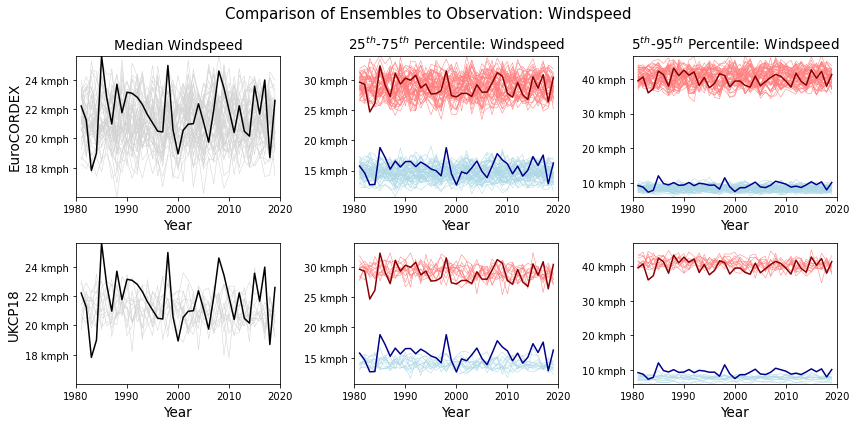

In [13]:
# Windspeed
cordex_lines = wind_cordex
ukcp18_lines = wind_ukcp18
obsrvd_lines = wind_obs*1.3 # Factor I had to multiply windspeed by to get a match of distributions
title_string = 'Windspeed'
save_str = 'sfcWind'


dates = [1981 + i for i in range(39)]


plt.rcParams["figure.figsize"] = (12,6)
fig,ax = plt.subplots(2,3)
fig.suptitle(f'Comparison of Ensembles to Observation: {title_string}',fontsize = 15)

cordex_plots = [ax[0,0].plot(dates,cordex_lines[i,:,2], color = '#d3d3d3',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1 = ax[0,0].plot(dates,obsrvd_lines[:,2], color = 'black', linewidth = 1.5)

ax[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax[0,0].set_ylim(min(np.min(cordex_lines[:,:,2]),np.min(obsrvd_lines[:,2]),np.min(ukcp18_lines[:,:,2])),
                 max(np.max(cordex_lines[:,:,2]),np.max(obsrvd_lines[:,2]),np.max(ukcp18_lines[:,:,2])))
ax[0,0].set_xlim(1980,2020)
ax[0,0].set_title(f'Median {title_string}',fontsize=13.5)
ax[0,0].set_ylabel('EuroCORDEX',fontsize=13.5)
ax[0,0].set_xlabel('Year',fontsize=13.5)

ukcp18_plots = [ax[1,0].plot(dates,ukcp18_lines[i,:,2], color = '#d3d3d3',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2 = ax[1,0].plot(dates,obsrvd_lines[:,2], color = 'black', linewidth = 1.5)

ax[1,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax[1,0].set_ylim(min(np.min(cordex_lines[:,:,2]),np.min(obsrvd_lines[:,2]),np.min(ukcp18_lines[:,:,2])),
                 max(np.max(cordex_lines[:,:,2]),np.max(obsrvd_lines[:,2]),np.max(ukcp18_lines[:,:,2])))
ax[1,0].set_xlim(1980,2020)
ax[1,0].set_ylabel('UKCP18',fontsize=13.5)
ax[1,0].set_xlabel('Year',fontsize=13.5)



cordex_plots_up = [ax[0,1].plot(dates,cordex_lines[i,:,3], color = '#FF7F7F',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_up = ax[0,1].plot(dates,obsrvd_lines[:,3], color = '#8B0000', linewidth = 1.5)
cordex_plots_lo = [ax[0,1].plot(dates,cordex_lines[i,:,1], color = '#add8e6',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_lo = ax[0,1].plot(dates,obsrvd_lines[:,1], color = '#00008B', linewidth = 1.5)

ax[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax[0,1].set_ylim(min(np.min(cordex_lines[:,:,1]),np.min(obsrvd_lines[:,1]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,3]),np.max(obsrvd_lines[:,3]),np.max(ukcp18_lines[:,:,3])))
ax[0,1].set_xlim(1980,2020)
ax[0,1].set_title(f'25$^t$$^h$-75$^t$$^h$ Percentile: {title_string}',fontsize=13.5)
ax[0,1].set_xlabel('Year',fontsize=13.5)

ukcp18_plots_up = [ax[1,1].plot(dates,ukcp18_lines[i,:,3], color = '#FF7F7F',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_up = ax[1,1].plot(dates,obsrvd_lines[:,3], color = '#8B0000', linewidth = 1.5)
ukcp18_plots_lo = [ax[1,1].plot(dates,ukcp18_lines[i,:,1], color = '#add8e6',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_lo = ax[1,1].plot(dates,obsrvd_lines[:,1], color = '#00008B', linewidth = 1.5)

ax[1,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax[1,1].set_ylim(min(np.min(cordex_lines[:,:,1]),np.min(obsrvd_lines[:,1]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,3]),np.max(obsrvd_lines[:,3]),np.max(ukcp18_lines[:,:,3])))
ax[1,1].set_xlim(1980,2020)
ax[1,1].set_xlabel('Year',fontsize=13.5)



cordex_plots_up = [ax[0,2].plot(dates,cordex_lines[i,:,4], color = '#FF7F7F',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
cordex_plots_lo = [ax[0,2].plot(dates,cordex_lines[i,:,0], color = '#add8e6',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_up = ax[0,2].plot(dates,obsrvd_lines[:,4], color = '#8B0000', linewidth = 1.5)
obsrvd_comp1_lo = ax[0,2].plot(dates,obsrvd_lines[:,0], color = '#00008B', linewidth = 1.5)

ax[0,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax[0,2].set_ylim(min(np.min(cordex_lines[:,:,0]),np.min(obsrvd_lines[:,0]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,4]),np.max(obsrvd_lines[:,4]),np.max(ukcp18_lines[:,:,3])))
ax[0,2].set_xlim(1980,2020)
ax[0,2].set_title(f'5$^t$$^h$-95$^t$$^h$ Percentile: {title_string}',fontsize=13.5)
ax[0,2].set_xlabel('Year',fontsize=13.5)

ukcp18_plots_up = [ax[1,2].plot(dates,ukcp18_lines[i,:,4], color = '#FF7F7F',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
ukcp18_plots_lo = [ax[1,2].plot(dates,ukcp18_lines[i,:,0], color = '#add8e6',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_up = ax[1,2].plot(dates,obsrvd_lines[:,4], color = '#8B0000', linewidth = 1.5)
obsrvd_comp2_lo = ax[1,2].plot(dates,obsrvd_lines[:,0], color = '#00008B', linewidth = 1.5)

ax[1,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax[1,2].set_ylim(min(np.min(cordex_lines[:,:,0]),np.min(obsrvd_lines[:,0]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,4]),np.max(obsrvd_lines[:,4]),np.max(ukcp18_lines[:,:,3])))
ax[1,2].set_xlim(1980,2020)
ax[1,2].set_xlabel('Year',fontsize=13.5)

plt.tight_layout()
plt.savefig(f'/home/theo/final_images/4.images/{save_str}_obs2ens')

###### Rainfall:

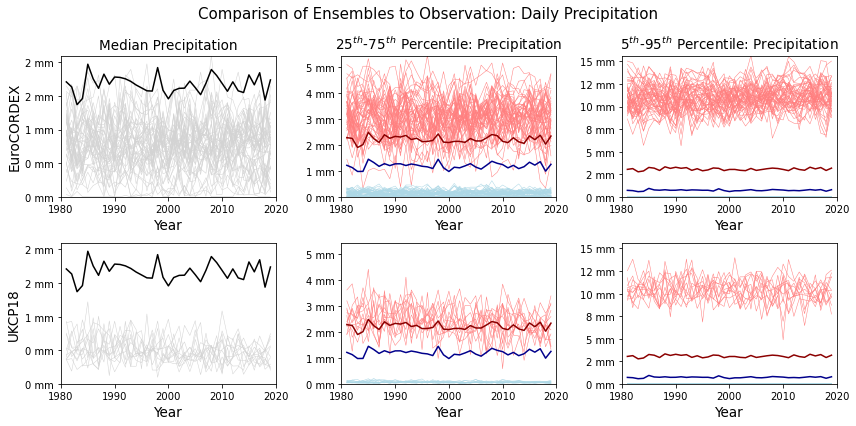

In [16]:
# Rainfall
cordex_lines = rain_cordex
ukcp18_lines = rain_ukcp18
obsrvd_lines = rain_obs*0.1
title_string = 'Precipitation'
save_str = 'pr'


dates = [1981 + i for i in range(39)]


plt.rcParams["figure.figsize"] = (12,6)
fig,ax = plt.subplots(2,3)
fig.suptitle(f'Comparison of Ensembles to Observation: Daily {title_string}',fontsize = 15)

cordex_plots = [ax[0,0].plot(dates,cordex_lines[i,:,2], color = '#d3d3d3',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1 = ax[0,0].plot(dates,obsrvd_lines[:,2], color = 'black', linewidth = 1.5)

ax[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax[0,0].set_ylim(min(np.min(cordex_lines[:,:,2]),np.min(obsrvd_lines[:,2]),np.min(ukcp18_lines[:,:,2])),
                 max(np.max(cordex_lines[:,:,2]),np.max(obsrvd_lines[:,2]),np.max(ukcp18_lines[:,:,2])))
ax[0,0].set_xlim(1980,2020)
ax[0,0].set_title(f'Median {title_string}',fontsize=13.5)
ax[0,0].set_ylabel('EuroCORDEX',fontsize=13.5)
ax[0,0].set_xlabel('Year',fontsize=13.5)

ukcp18_plots = [ax[1,0].plot(dates,ukcp18_lines[i,:,2], color = '#d3d3d3',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2 = ax[1,0].plot(dates,obsrvd_lines[:,2], color = 'black', linewidth = 1.5)

ax[1,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax[1,0].set_ylim(min(np.min(cordex_lines[:,:,2]),np.min(obsrvd_lines[:,2]),np.min(ukcp18_lines[:,:,2])),
                 max(np.max(cordex_lines[:,:,2]),np.max(obsrvd_lines[:,2]),np.max(ukcp18_lines[:,:,2])))
ax[1,0].set_xlim(1980,2020)
ax[1,0].set_ylabel('UKCP18',fontsize=13.5)
ax[1,0].set_xlabel('Year',fontsize=13.5)



cordex_plots_up = [ax[0,1].plot(dates,cordex_lines[i,:,3], color = '#FF7F7F',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_up = ax[0,1].plot(dates,obsrvd_lines[:,3], color = '#8B0000', linewidth = 1.5)
cordex_plots_lo = [ax[0,1].plot(dates,cordex_lines[i,:,1], color = '#add8e6',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_lo = ax[0,1].plot(dates,obsrvd_lines[:,1], color = '#00008B', linewidth = 1.5)

ax[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax[0,1].set_ylim(min(np.min(cordex_lines[:,:,1]),np.min(obsrvd_lines[:,1]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,3]),np.max(obsrvd_lines[:,3]),np.max(ukcp18_lines[:,:,3])))
ax[0,1].set_xlim(1980,2020)
ax[0,1].set_title(f'25$^t$$^h$-75$^t$$^h$ Percentile: {title_string}',fontsize=13.5)
ax[0,1].set_xlabel('Year',fontsize=13.5)

ukcp18_plots_up = [ax[1,1].plot(dates,ukcp18_lines[i,:,3], color = '#FF7F7F',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_up = ax[1,1].plot(dates,obsrvd_lines[:,3], color = '#8B0000', linewidth = 1.5)
ukcp18_plots_lo = [ax[1,1].plot(dates,ukcp18_lines[i,:,1], color = '#add8e6',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_lo = ax[1,1].plot(dates,obsrvd_lines[:,1], color = '#00008B', linewidth = 1.5)

ax[1,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax[1,1].set_ylim(min(np.min(cordex_lines[:,:,1]),np.min(obsrvd_lines[:,1]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,3]),np.max(obsrvd_lines[:,3]),np.max(ukcp18_lines[:,:,3])))
ax[1,1].set_xlim(1980,2020)
ax[1,1].set_xlabel('Year',fontsize=13.5)



cordex_plots_up = [ax[0,2].plot(dates,cordex_lines[i,:,4], color = '#FF7F7F',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
cordex_plots_lo = [ax[0,2].plot(dates,cordex_lines[i,:,0], color = '#add8e6',linewidth = 0.5) for i in range(cordex_lines.shape[0])]
obsrvd_comp1_up = ax[0,2].plot(dates,obsrvd_lines[:,4], color = '#8B0000', linewidth = 1.5)
obsrvd_comp1_lo = ax[0,2].plot(dates,obsrvd_lines[:,0], color = '#00008B', linewidth = 1.5)

ax[0,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax[0,2].set_ylim(min(np.min(cordex_lines[:,:,0]),np.min(obsrvd_lines[:,0]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,4]),np.max(obsrvd_lines[:,4]),np.max(ukcp18_lines[:,:,3])))
ax[0,2].set_xlim(1980,2020)
ax[0,2].set_title(f'5$^t$$^h$-95$^t$$^h$ Percentile: {title_string}',fontsize=13.5)
ax[0,2].set_xlabel('Year',fontsize=13.5)

ukcp18_plots_up = [ax[1,2].plot(dates,ukcp18_lines[i,:,4], color = '#FF7F7F',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
ukcp18_plots_lo = [ax[1,2].plot(dates,ukcp18_lines[i,:,0], color = '#add8e6',linewidth = 0.5) for i in range(ukcp18_lines.shape[0])]
obsrvd_comp2_up = ax[1,2].plot(dates,obsrvd_lines[:,4], color = '#8B0000', linewidth = 1.5)
obsrvd_comp2_lo = ax[1,2].plot(dates,obsrvd_lines[:,0], color = '#00008B', linewidth = 1.5)

ax[1,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax[1,2].set_ylim(min(np.min(cordex_lines[:,:,0]),np.min(obsrvd_lines[:,0]),np.min(ukcp18_lines[:,:,1])),
                 max(np.max(cordex_lines[:,:,4]),np.max(obsrvd_lines[:,4]),np.max(ukcp18_lines[:,:,3])))
ax[1,2].set_xlim(1980,2020)
ax[1,2].set_xlabel('Year',fontsize=13.5)

plt.tight_layout()
plt.savefig(f'/home/theo/final_images/4.images/{save_str}_obs2ens')

In [130]:
tas_obs_nc = xarray.open_dataset('/home/theo/data/tas_OSGB_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
wnd_obs_nc = xarray.open_dataset('/home/theo/data/sfcWind_OSGB_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")
prc_obs_nc = xarray.open_dataset('/home/theo/data/pr_OSGB_ECMWF-ERAINT_day_19801201-20190831.nc', engine = "netcdf4")

prc_obs_nc

<xarray.Dataset>
Dimensions:  (time: 14153, x: 82, y: 112)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2019-08-31
  * x        (x) float64 -2.1e+05 -1.98e+05 -1.86e+05 ... 7.5e+05 7.62e+05
  * y        (y) float64 -1.02e+05 -9e+04 -7.8e+04 ... 1.218e+06 1.23e+06
Data variables:
    crs      int32 ...
    pr       (time, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 28 08:45:35 2021: cdo remapbil,/data/met/processing...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...